<h2> Lab 8

<h3> Exercise Set 1

(a) Scenario 1: You have a dataset of 300 documents containing numerical and text records of different nuclear units. Your task is to develop a model that can process similar documents and classify the data based on reactor design (PWR or BWR) and the length of the reactor life (< 40 years, > 40 years but < 60 years, > 60 years).

Needs to handle binary and continuous classification, small sample size, loss could be categorical crossentropy, how to rectify the two outputs?


(b) Scenario 2: You have a dataset of 5000 images of different pipes in a nuclear power plant unit. Your task is to develop a model that can predict the health of similar pipes and classify them into different grades: High, medium, low, or about to break.

Handles image classification, loss could be categorical crossentropy

(c) Scenario 3: You have a dataset of 100,000 time-dependent measurements of reactor pressure (MPa), fuel temperature (Kelvin), and mass flow rate of coolant (kg/s). Your task is to develop a model that predicts the coolant (water) level in the core in meters as a function of time

large dataset of time-dependent measurements, loss could be absolute squared error

(d) Scenario 4: You have a dataset of static nuclear data (cross-section) measurements taken from a nuclear laboratory for isotopes like U-235, U-238, Pu-239, Pu-240, and other actinides (Am, Cm) and fission products (Cs, Sm). Your task is to develop a model that can predict the value of $ k_{eff} $ based on these cross-section data.




<h3> Exercise Set 2

<h4>----------- Cut File -----------

(a) The correlation matrices of the input data (between the input themselves) and output data
(between the output themselves).
(b) The datafarme that shows the model ranking after tuning.
(c) The diagonal validation plot for an output of your choice (first output by default).
(d) The percent error plot for five outputs of your choice.
(e) The convergence of the Bayesian optimizer for the neural network.
(f) The neural network loss curve for the best neural network model.
(g) Discuss your observations of the performance of the methods and the results you
found.


In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

ModuleNotFoundError: No module named 'xarray'

In [2]:
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

ModuleNotFoundError: No module named 'pyMAISE'

In [3]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

In [4]:
#load the input and output dataframes from github
xdf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_x.csv')
ydf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_y.csv')

xnames=xdf.columns
ynames=ydf.columns

# Convert np arrays into xarrays
x = xr.DataArray(xdf, name="Input data", dims=["Samples", "Features"], coords={"Features":xnames})
y = xr.DataArray(ydf, name="Target data",dims=["Samples", "Features"], coords={"Features":ynames})

NameError: name 'pd' is not defined

<h3>----------- Cut File -----------

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].set_title("Input Data Correlation")
ax[1].set_title("Output Data Correlation")
correlation_matrix(x, ax=ax[0], fig=fig)
correlation_matrix(y, ax=ax[1], fig=fig)
fig.set_figwidth(20)

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[x, y], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

In [ ]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200, 
    #n_iter=3, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    #max_trials=3,
    cv=5,
)

In [ ]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])
plt.show()

In [ ]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest),
    model_configs=[random_search_configs, bayesian_search_configs],
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 300}},
    },
    yscaler=yscaler,
)

postprocessor.metrics().drop("Parameter Configurations", axis=1)

In [ ]:
ax = postprocessor.diagonal_validation_plot(model_type='Linear')
plt.show()

In [ ]:
models = ["Linear", "Lasso", "DT", "RF", "KN"]
i = 0
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

In [ ]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

In [ ]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

In [ ]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

In [ ]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

In [ ]:
postprocessor.nn_learning_plot()
plt.show()

In [ ]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

<h3> Exercise Set 3

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2  #for plotting the MIT reactor core
#Sklearn tools
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#Keras specials
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

#load the input and output dataframes from github
xdf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_x.csv')
ydf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_y.csv')
xtrain, xtest, ytrain, ytest = train_test_split(xdf.values, ydf.values, random_state=42, test_size=0.2)
xscaler = MinMaxScaler()
yscaler = MinMaxScaler()
Xtrain = xscaler.fit_transform(xtrain)
Xtest = xscaler.transform(xtest)
Ytrain = yscaler.fit_transform(ytrain)
Ytest = yscaler.transform(ytest)

num_dens_layers = 5                     #including the input/first layer
n_nodes=[50, 200, 200, 200, 200]  #node per layer
model = Sequential()
model.add(Input(shape=(Xtrain.shape[1],)))
model.add(Dense(n_nodes[0], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
for i in range(1,num_dens_layers):
    model.add(Dense(n_nodes[i], kernel_initializer='normal',activation='relu')) #Last layer (use linear activation and set nodes to number of Y columns/labels/outputs
model.add(Dense(Ytrain.shape[1], kernel_initializer='normal',activation='linear'))

model.compile(loss='mean_absolute_error', optimizer=Adam(6e-4), metrics=['mean_absolute_error'])
model.summary()
cp = ModelCheckpoint('best_model_manual_tuning.keras', monitor='val_mean_absolute_error', save_best_only=True, mode='min', verbose=1)
history = model.fit(Xtrain, Ytrain, epochs=100, batch_size=8, validation_split = 0.15, callbacks=cp, verbose=True)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 50)             │         1,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 200)            │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 30)             │         6,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,880 (538.59 KB)

 Trainable params: 137,880 (538.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
78/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3729 - mean_absolute_error: 0.3729
Epoch 1: val_mean_absolute_error improved from inf to 0.10739, saving model to best_model_manual_tuning.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3557 - mean_absolute_error: 0.3557 - val_loss: 0.1074 - val_mean_absolute_error: 0.1074
Epoch 2/100
65/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1133 - mean_absolute_error: 0.1133
Epoch 2: val_mean_absolute_error did not improve from 0.10739
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1127 - mean_absolute_error: 0.1127 - val_loss: 0.1074 - val_mean_absolute_error: 0.1074
Epoch 3/100
70/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1077 - mean_absolute_error: 0.1077
Epoch 3: val_mean_absolute_error improved from 0.10739 to 0.10410, saving model to best_model_manual_tuning.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1076 - mean_absolute_error: 0.1076 - val_loss: 0.1041 - val_mean_absolute_error: 0.1041
Epoch 4/100
66/

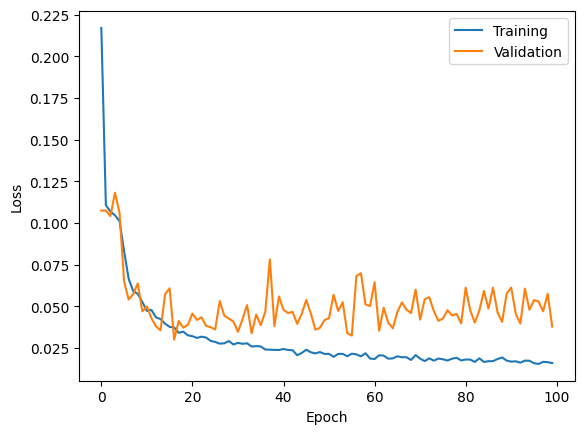

In [19]:
train_err=history.history['mean_absolute_error']
val_err=history.history['val_mean_absolute_error']
plt.figure()
plt.plot(train_err, label='Training')
plt.plot(val_err, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [22]:
print(xdf.columns)
pred_0 = model.predict(Xtrain)
#baseline = mean_absolute_error(Ytrain, Xtrain)
for feature in xdf.columns:
    xdf.loc[:,feature] = np.random.uniform(0, 1, xdf.loc[:,feature].size)
ydf.loc[0,'TE_4_t4000']

Index(['sf', 'por', 'msf_6', 'msf_7', 'msf_8', 'msf_9', 'msf_10', 'msf_11',
       'msf_12', 'msf_13', 'msf_14', 'msf_15', 'msf_16', 'msf_17', 'msf_18',
       'msf_19', 'msf_20', 'msf_21', 'msf_22', 'msf_23'],
      dtype='object')


453.5125427246094